In [ ]:
!pip install -q mnists

In [ ]:
!pip install -q equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from jaxtyping import Array, Float, Int, PyTree
import jax.tree_util as jtu

In [ ]:
import mnists
import numpy as np
from sklearn.model_selection import train_test_split

dataset = mnists.MNIST()

X_train = dataset.train_images().astype(np.float32) / 255.0
y_train = dataset.train_labels().astype(np.int32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0,
)

X_test = dataset.test_images().astype(np.float32) / 255.0
y_test = dataset.test_labels().astype(np.int32)

BATCH_SIZE = 512

In [ ]:
def batch_data(X, y, batch_size):
    for i in range(0, len(y), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

X_dummy, y_dummy = next(iter(batch_data(X_train, y_train, BATCH_SIZE)))
X_dummy.shape, y_dummy.shape

((512, 28, 28), (512,))

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
from functools import partial


class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 5)
        self.layers = [

            eqx.nn.Conv2d(1, 16, kernel_size=5, padding=2, key=keys[0]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2, stride=2),
            eqx.nn.Conv2d(16, 64, kernel_size=5, key=keys[1]),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2, stride=2),
            jnp.ravel,
            eqx.nn.Linear(1600, 128, key=keys[2]),
            jax.nn.relu,
            eqx.nn.Linear(128, 64, key=keys[3]),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=keys[4]),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

key, subkey = jax.random.split(key, 2)
model = CNN(subkey)
model

CNN(
  layers=[
    <wrapped function expand_dims>,
    Conv2d(
      num_spatial_dims=2,
      weight=f32[16,1,5,5],
      bias=f32[16,1,1],
      in_channels=1,
      out_channels=16,
      kernel_size=(5, 5),
      stride=(1, 1),
      padding=((2, 2), (2, 2)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    <wrapped function relu>,
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(2, 2),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    Conv2d(
      num_spatial_dims=2,
      weight=f32[64,16,5,5],
      bias=f32[64,1,1],
      in_channels=16,
      out_channels=64,
      kernel_size=(5, 5),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    <wrapped function relu>,
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spa

In [ ]:
def cross_entropy(
    y: Int[Array, "batch"],
    pred_y: Float[Array, "batch 10"],
) -> Float[Array, ""]:
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

def loss(
    model: CNN,
    x: Float[Array, "batch 28 28"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


loss_val = loss(model, X_dummy, y_dummy)
print(loss_val)
output = jax.vmap(model)(X_dummy)
output.shape

2.3131888


(512, 10)

In [ ]:
#jax.value_and_grad(loss)(model, X_dummy, y_dummy)

In [ ]:
params, static = eqx.partition(model, eqx.is_array)

def loss2(params, static, x, y):
    model = eqx.combine(params, static)
    return loss(model, x, y)

loss_value, grads = jax.value_and_grad(loss2)(params, static, X_dummy, y_dummy)
loss_value, type(grads)

(Array(2.3131888, dtype=float32), __main__.CNN)

In [ ]:
value, grads = eqx.filter_value_and_grad(loss)(model, X_dummy, y_dummy)
value, type(grads)

(Array(2.3131888, dtype=float32), __main__.CNN)

In [ ]:
loss = eqx.filter_jit(loss)

@eqx.filter_jit
def compute_accuracy(
    model: CNN,
    x: Float[Array, "batch 28 28"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

compute_accuracy(model, X_dummy, y_dummy)

Array(0.08007812, dtype=float32)

In [ ]:
def evaluate(model, X_test, y_test):
    avg_loss = 0
    avg_acc = 0
    n_batches = (len(X_test) + BATCH_SIZE - 1) // BATCH_SIZE
    for x, y in batch_data(X_test, y_test, BATCH_SIZE):
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / n_batches, avg_acc / n_batches

In [ ]:
evaluate(model, X_test, y_test)

(Array(2.3114197, dtype=float32), Array(0.08891889, dtype=float32))

In [ ]:
optim = optax.adamw(1e-3)

In [ ]:
def train(
    model: CNN,
    X_train, y_train, X_test, y_test,
    optim: optax.GradientTransformation,
    epochs: int, print_every: int,
) -> CNN:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 28 28"],
        y: Int[Array, "batch"],
    ):
        loss_val, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_val

    n_batches = (len(X_train) + BATCH_SIZE - 1) // BATCH_SIZE

    try:
        for epoch in range(epochs):
            avg_train_loss = 0
            for x, y in batch_data(X_train, y_train, BATCH_SIZE):
                model, opt_state, train_loss = make_step(model, opt_state, x, y)
                avg_train_loss += train_loss

            if (epoch + 1) % print_every == 0:
                test_loss, test_accuracy = evaluate(model, X_test, y_test)
                print(
                    f"[{epoch + 1:3d}] train_loss={train_loss.item()/n_batches:2.3f} "
                    f"test_loss={test_loss.item():2.3f} test_accuracy={test_accuracy.item():2.3f}"
                )
    except KeyboardInterrupt:
        pass
    return model

In [ ]:
trained_model = train(model, X_train, y_train, X_test, y_test, optim=optim, epochs=100, print_every=1)

[  1] train_loss=0.001 test_loss=0.171 test_accuracy=0.950
[  2] train_loss=0.001 test_loss=0.093 test_accuracy=0.969
[  3] train_loss=0.001 test_loss=0.072 test_accuracy=0.977
[  4] train_loss=0.000 test_loss=0.057 test_accuracy=0.983
[  5] train_loss=0.000 test_loss=0.048 test_accuracy=0.984
[  6] train_loss=0.000 test_loss=0.042 test_accuracy=0.986
[  7] train_loss=0.000 test_loss=0.041 test_accuracy=0.987
[  8] train_loss=0.000 test_loss=0.040 test_accuracy=0.986
[  9] train_loss=0.000 test_loss=0.038 test_accuracy=0.986
[ 10] train_loss=0.000 test_loss=0.038 test_accuracy=0.987
[ 11] train_loss=0.000 test_loss=0.036 test_accuracy=0.987
[ 12] train_loss=0.000 test_loss=0.036 test_accuracy=0.989
[ 13] train_loss=0.000 test_loss=0.033 test_accuracy=0.990
[ 14] train_loss=0.000 test_loss=0.034 test_accuracy=0.990
[ 15] train_loss=0.000 test_loss=0.029 test_accuracy=0.991
[ 16] train_loss=0.000 test_loss=0.033 test_accuracy=0.990
[ 17] train_loss=0.000 test_loss=0.035 test_accuracy=0.9

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
class VisReceptiveFields(eqx.Module):
    img: Float[Array, "28 28"]
    layers: list

    def __init__(self, img, layers):
        self.img = jnp.array(img)
        self.layers = layers

    def __call__(self):
        x = self.img
        for layer in self.layers:
            x = layer(x)
        return x

vis_model = VisReceptiveFields(jax.random.uniform(jax.random.PRNGKey(0), (28, 28)), trained_model.layers[:3])
vis_model

VisReceptiveFields(
  img=f32[28,28],
  layers=[
    <wrapped function expand_dims>,
    Conv2d(
      num_spatial_dims=2,
      weight=f32[16,1,5,5],
      bias=f32[16,1,1],
      in_channels=1,
      out_channels=16,
      kernel_size=(5, 5),
      stride=(1, 1),
      padding=((2, 2), (2, 2)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    <wrapped function relu>
  ]
)

In [ ]:
vis_model().shape

(16, 28, 28)

In [ ]:
filter_spec = jtu.tree_map(lambda _: False, vis_model)
filter_spec = eqx.tree_at(lambda tree: tree.img, filter_spec, replace=True)

In [ ]:
def train_vis(
    model: VisReceptiveFields,
    optim: optax.GradientTransformation,
    epochs: int, print_every: int,
    filter_idx: int,
    filter_spec
):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
    ):
        def loss_vis(diff_model, static_model):
            model = eqx.combine(diff_model, static_model)
            activations = model()
            activations = activations[filter_idx, 1:-1, 1:-1]
            # activations = activations[filter_idx]
            return -jnp.mean(activations)

        diff_model, static_model = eqx.partition(model, filter_spec)
        loss_val, grads = eqx.filter_value_and_grad(loss_vis)(diff_model, static_model)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_val

    for epoch in range(epochs):
        model, opt_state, loss_val = make_step(model, opt_state)

        if (epoch + 1) % print_every == 0:
            print(f"[{epoch + 1:3d}] loss={loss_val.item():2.3f}")

    return model

In [ ]:
trained_vis_model = train_vis(vis_model, optim, 1000, 100, filter_idx=1, filter_spec=filter_spec)

[100] loss=-0.284
[200] loss=-0.357
[300] loss=-0.431
[400] loss=-0.506
[500] loss=-0.583
[600] loss=-0.663
[700] loss=-0.741
[800] loss=-0.820
[900] loss=-0.898
[1000] loss=-0.975


In [ ]:
vis_model().shape

(16, 28, 28)

In [ ]:
def visualize_receptive_field(img, layers, filter_idx, optim, epochs, print_every):
    vis_model = VisReceptiveFields(img, layers)
    filter_spec = jtu.tree_map(lambda _: False, vis_model)
    filter_spec = eqx.tree_at(lambda tree: tree.img, filter_spec, replace=True)
    vis_model = train_vis(vis_model, optim, epochs, print_every, filter_idx, filter_spec)
    img = vis_model.img
    img = img - img.min()
    img = img / img.max()
    return img

In [ ]:
trained_model.layers

[functools.partial(<function expand_dims at 0x7e0317996170>, axis=0),
 Conv2d(
   num_spatial_dims=2,
   weight=f32[16,1,5,5],
   bias=f32[16,1,1],
   in_channels=1,
   out_channels=16,
   kernel_size=(5, 5),
   stride=(1, 1),
   padding=((2, 2), (2, 2)),
   dilation=(1, 1),
   groups=1,
   use_bias=True,
   padding_mode='ZEROS'
 ),
 MaxPool2d(
   init=-inf,
   operation=<function max>,
   num_spatial_dims=2,
   kernel_size=(2, 2),
   stride=(2, 2),
   padding=((0, 0), (0, 0)),
   use_ceil=False
 ),
 Conv2d(
   num_spatial_dims=2,
   weight=f32[64,16,5,5],
   bias=f32[64,1,1],
   in_channels=16,
   out_channels=64,
   kernel_size=(5, 5),
   stride=(1, 1),
   padding=((0, 0), (0, 0)),
   dilation=(1, 1),
   groups=1,
   use_bias=True,
   padding_mode='ZEROS'
 ),
 MaxPool2d(
   init=-inf,
   operation=<function max>,
   num_spatial_dims=2,
   kernel_size=(2, 2),
   stride=(2, 2),
   padding=((0, 0), (0, 0)),
   use_ceil=False
 ),
 <PjitFunction of <function ravel at 0x7e0317995240>>,
 Li

In [ ]:
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]

    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]

    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

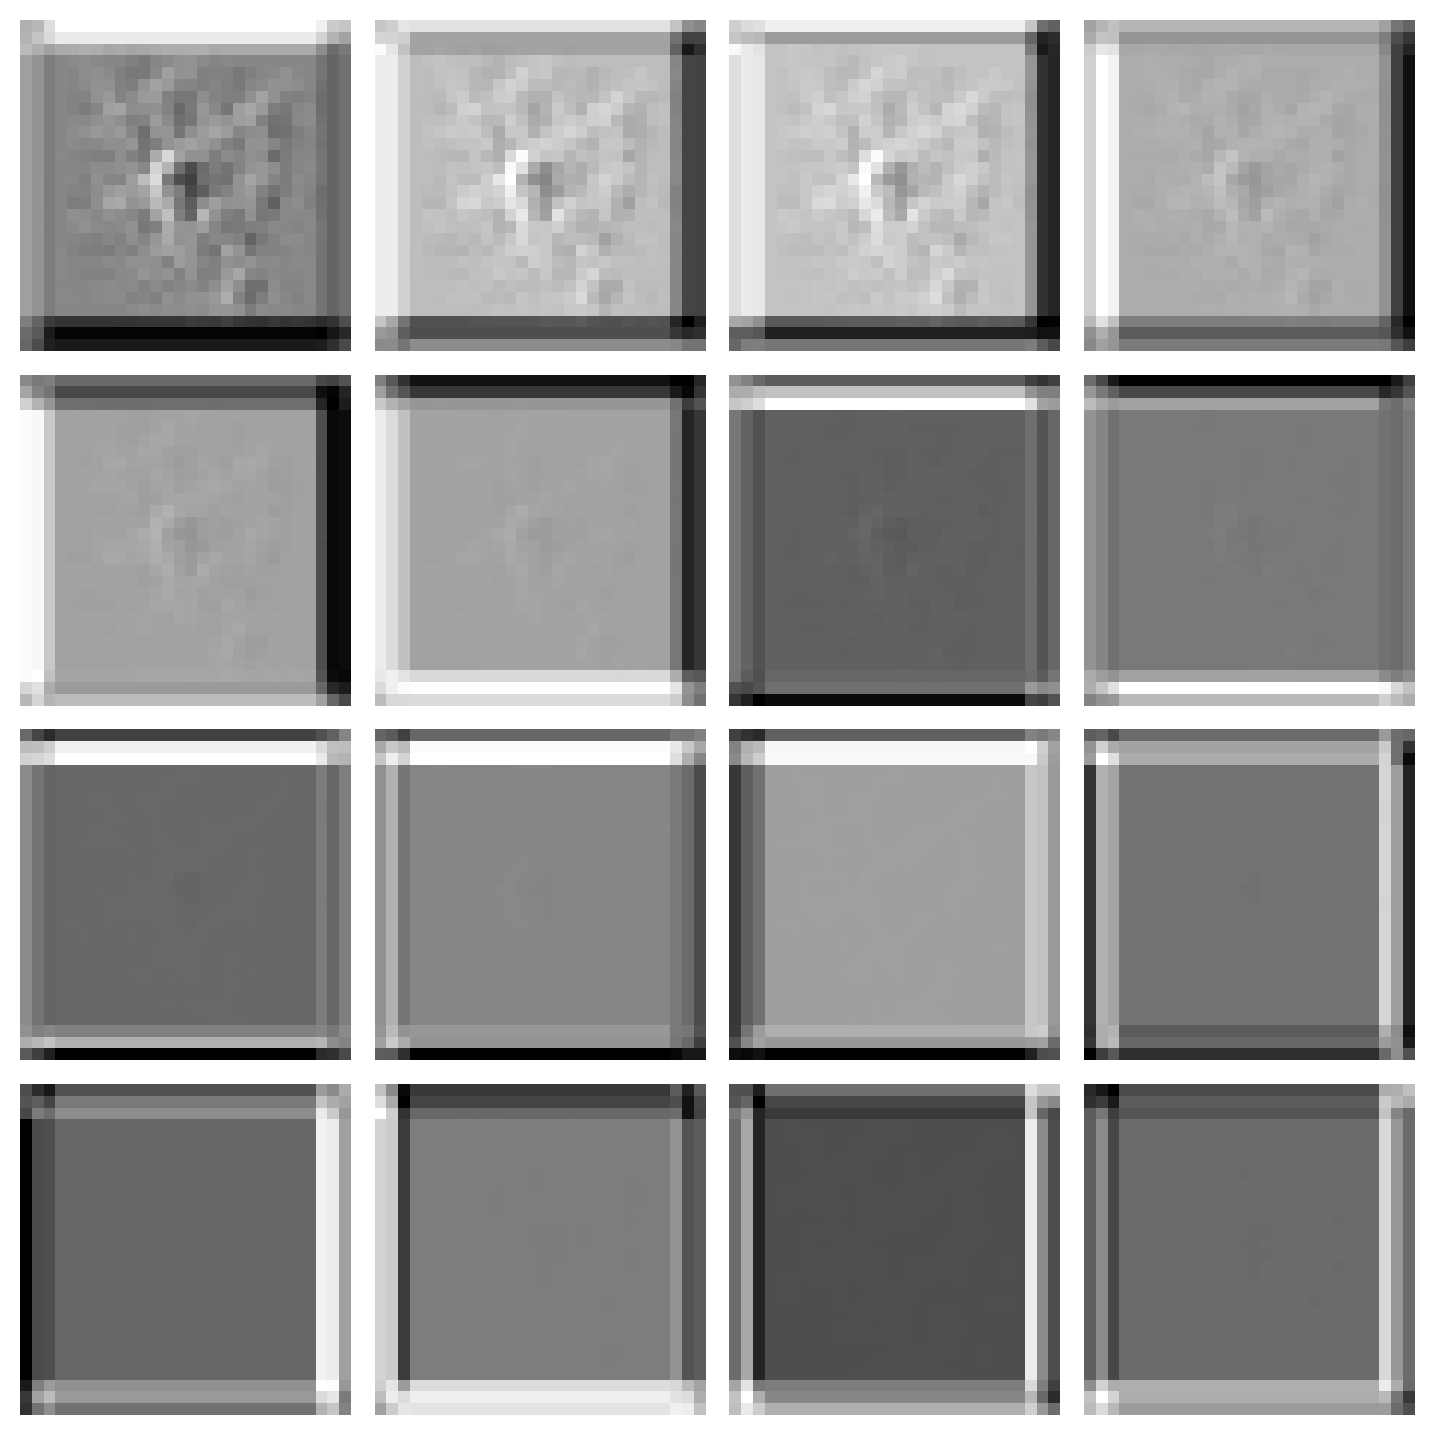

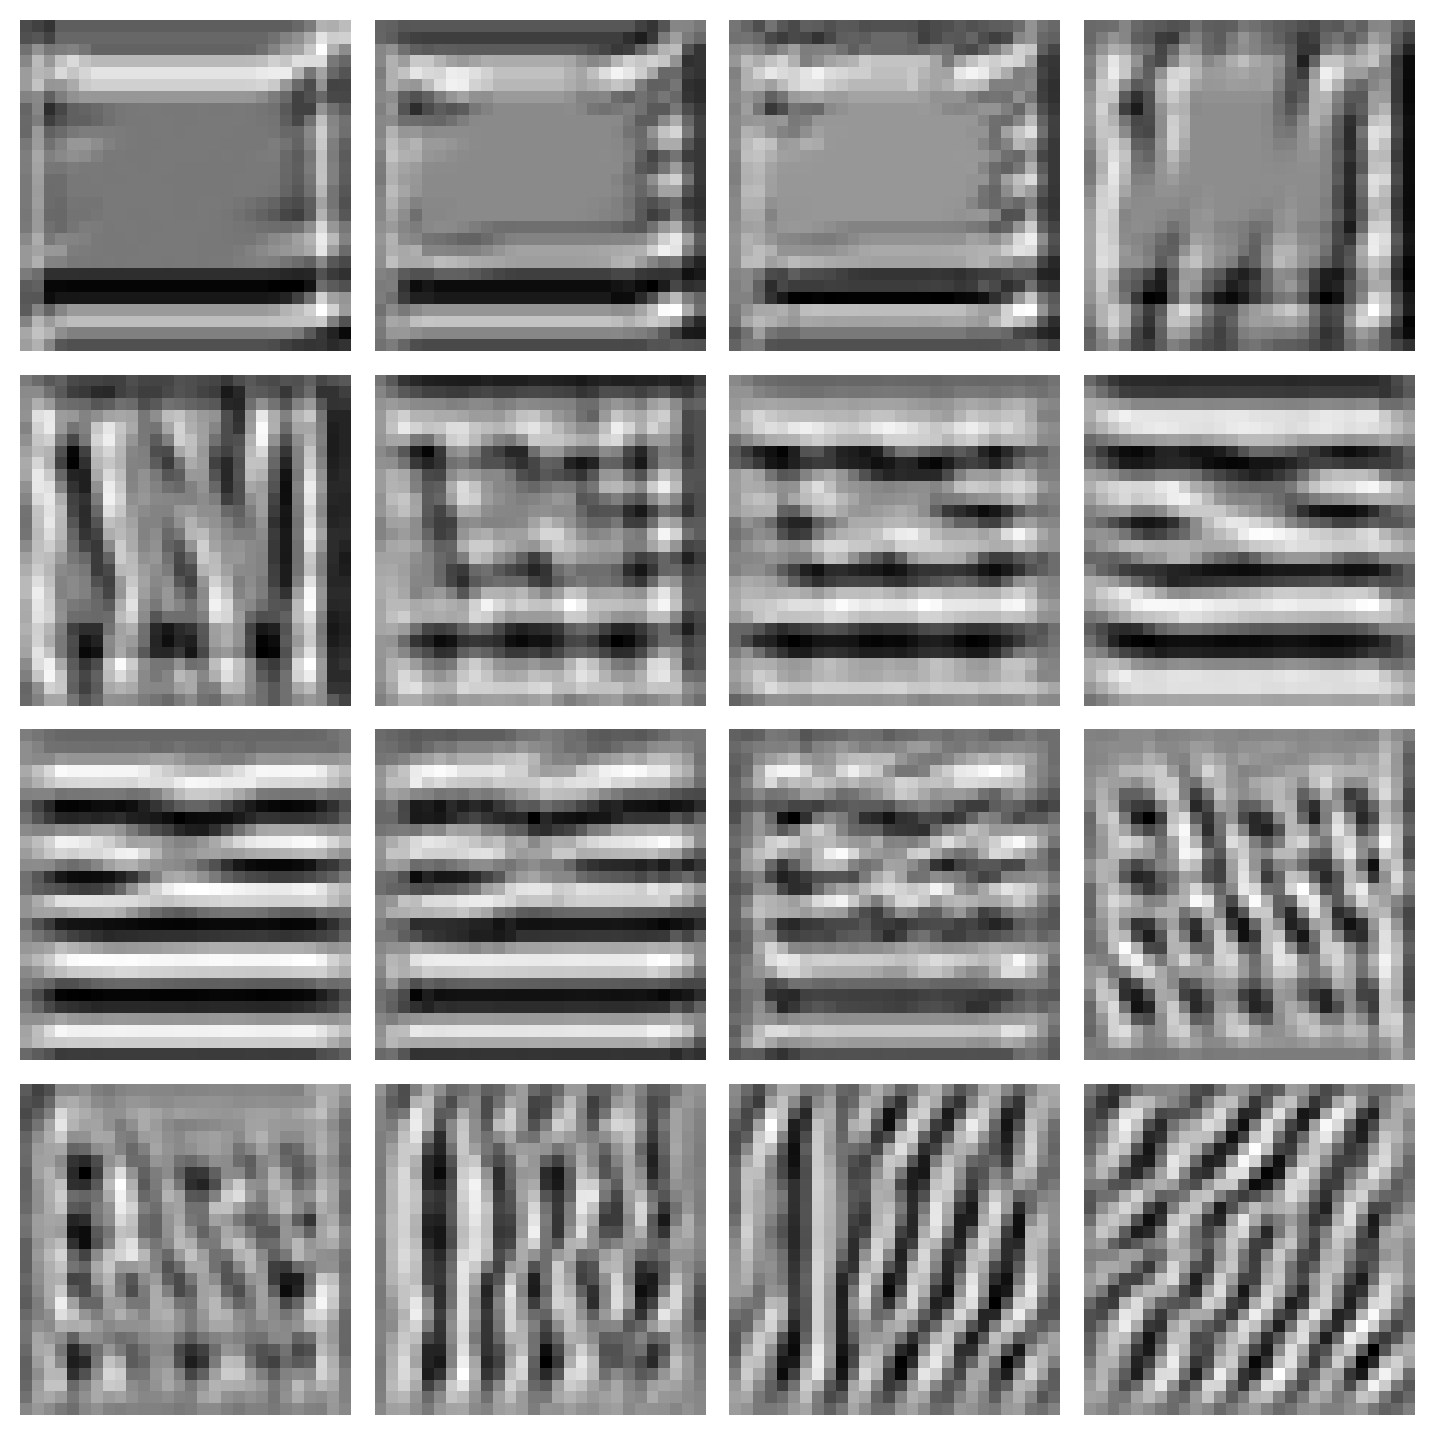

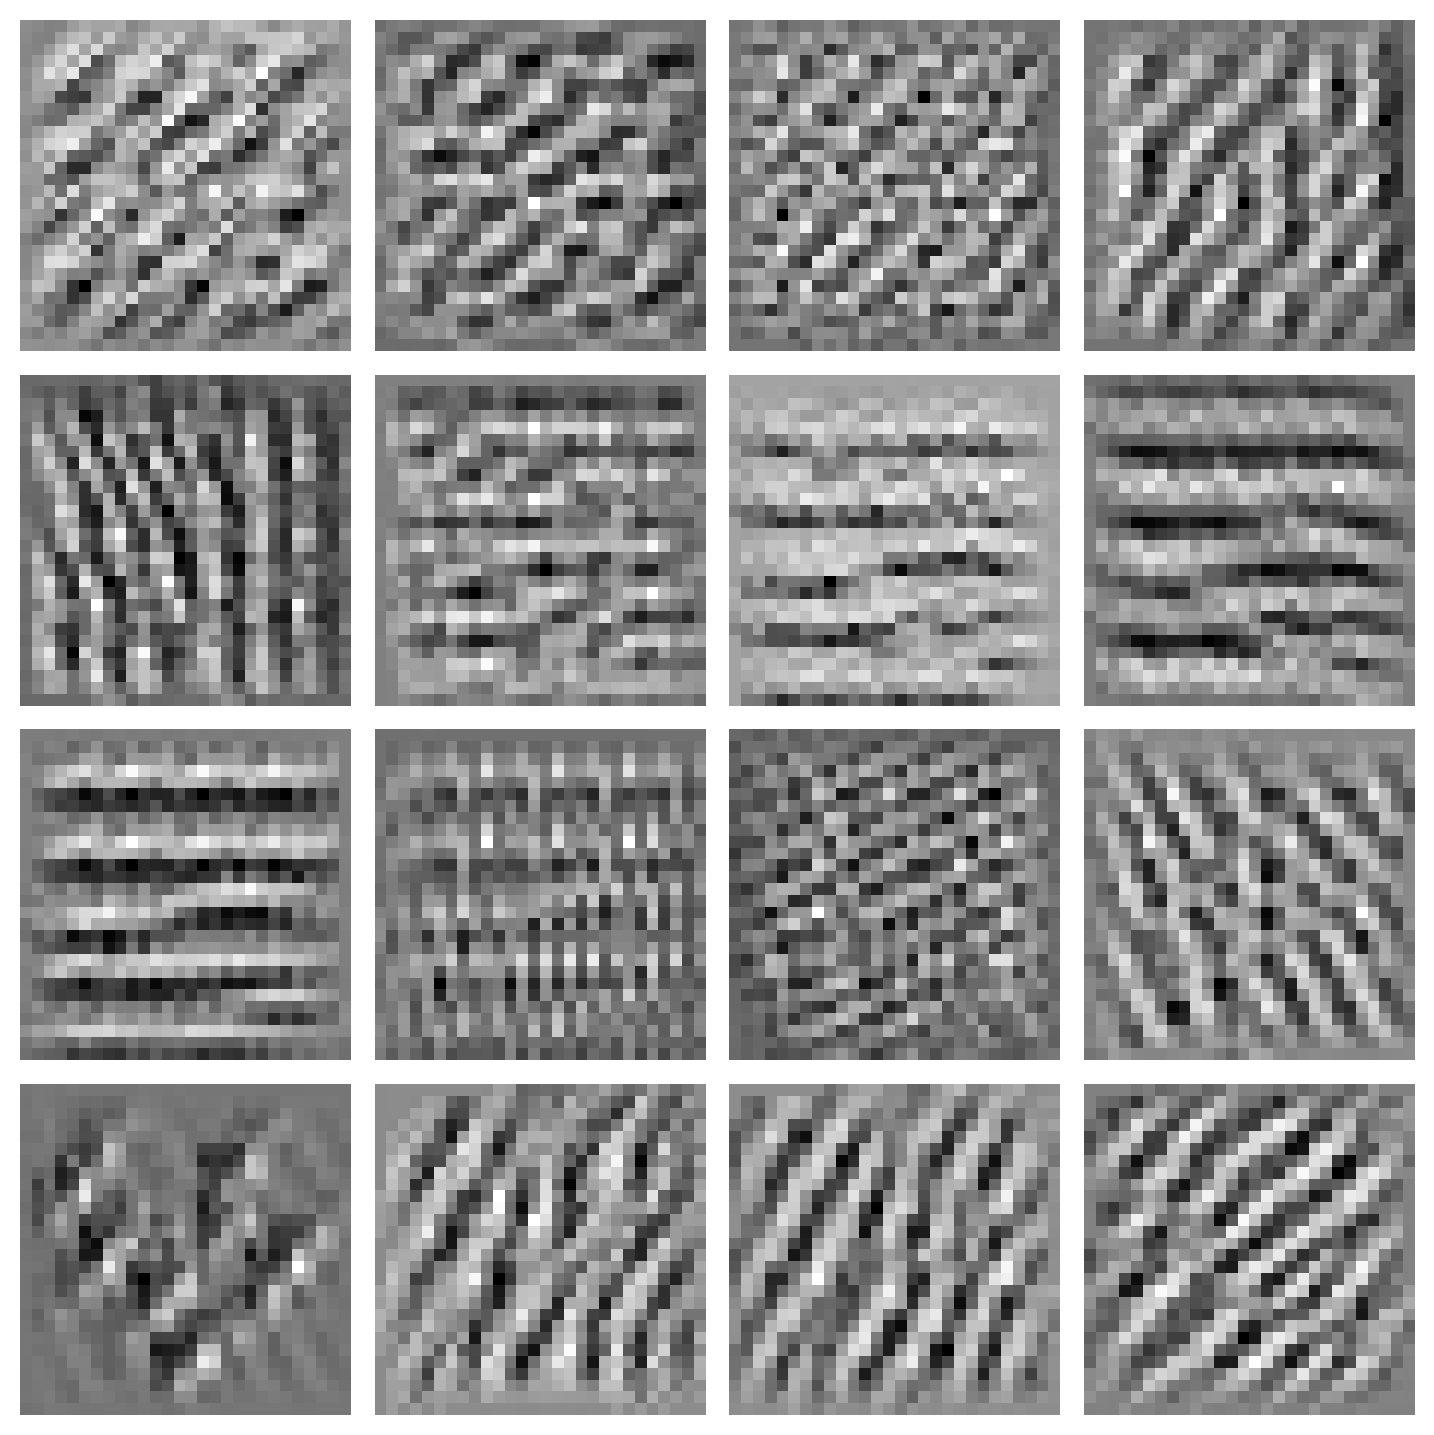

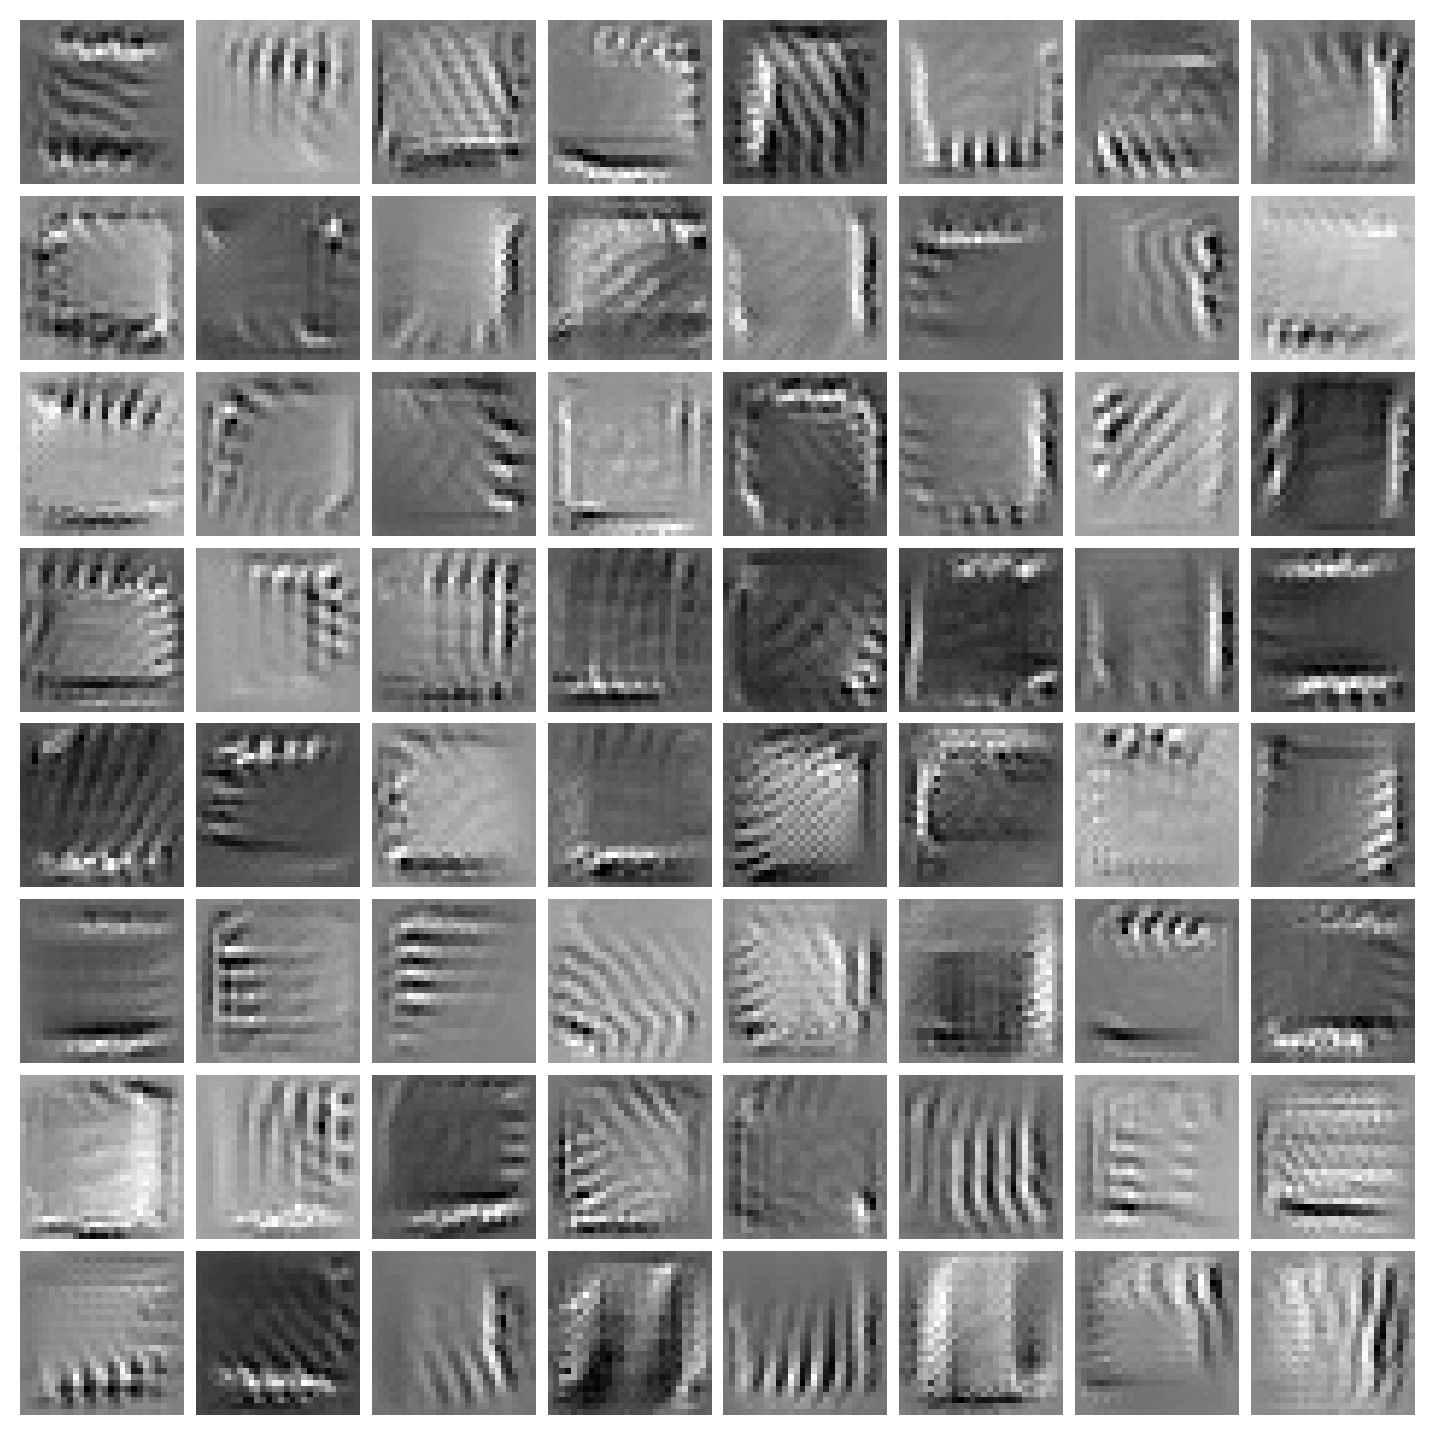

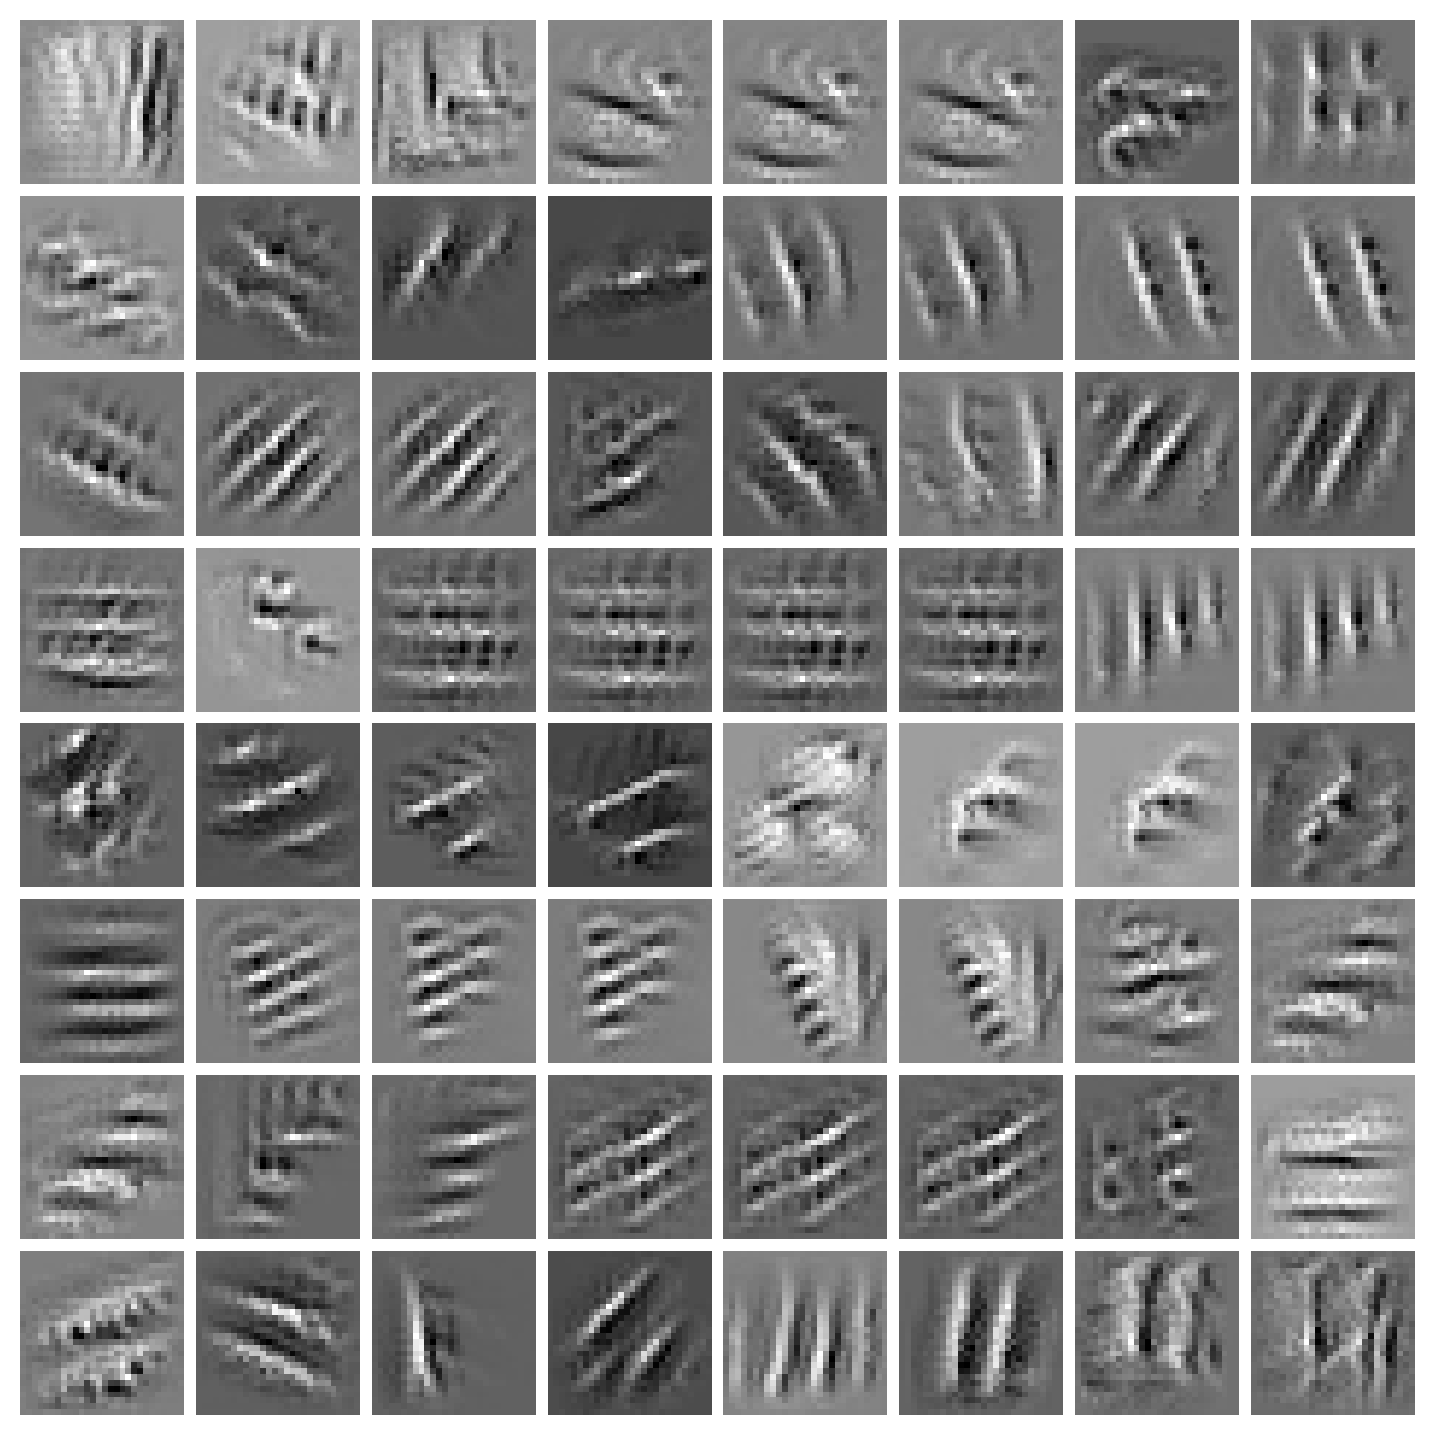

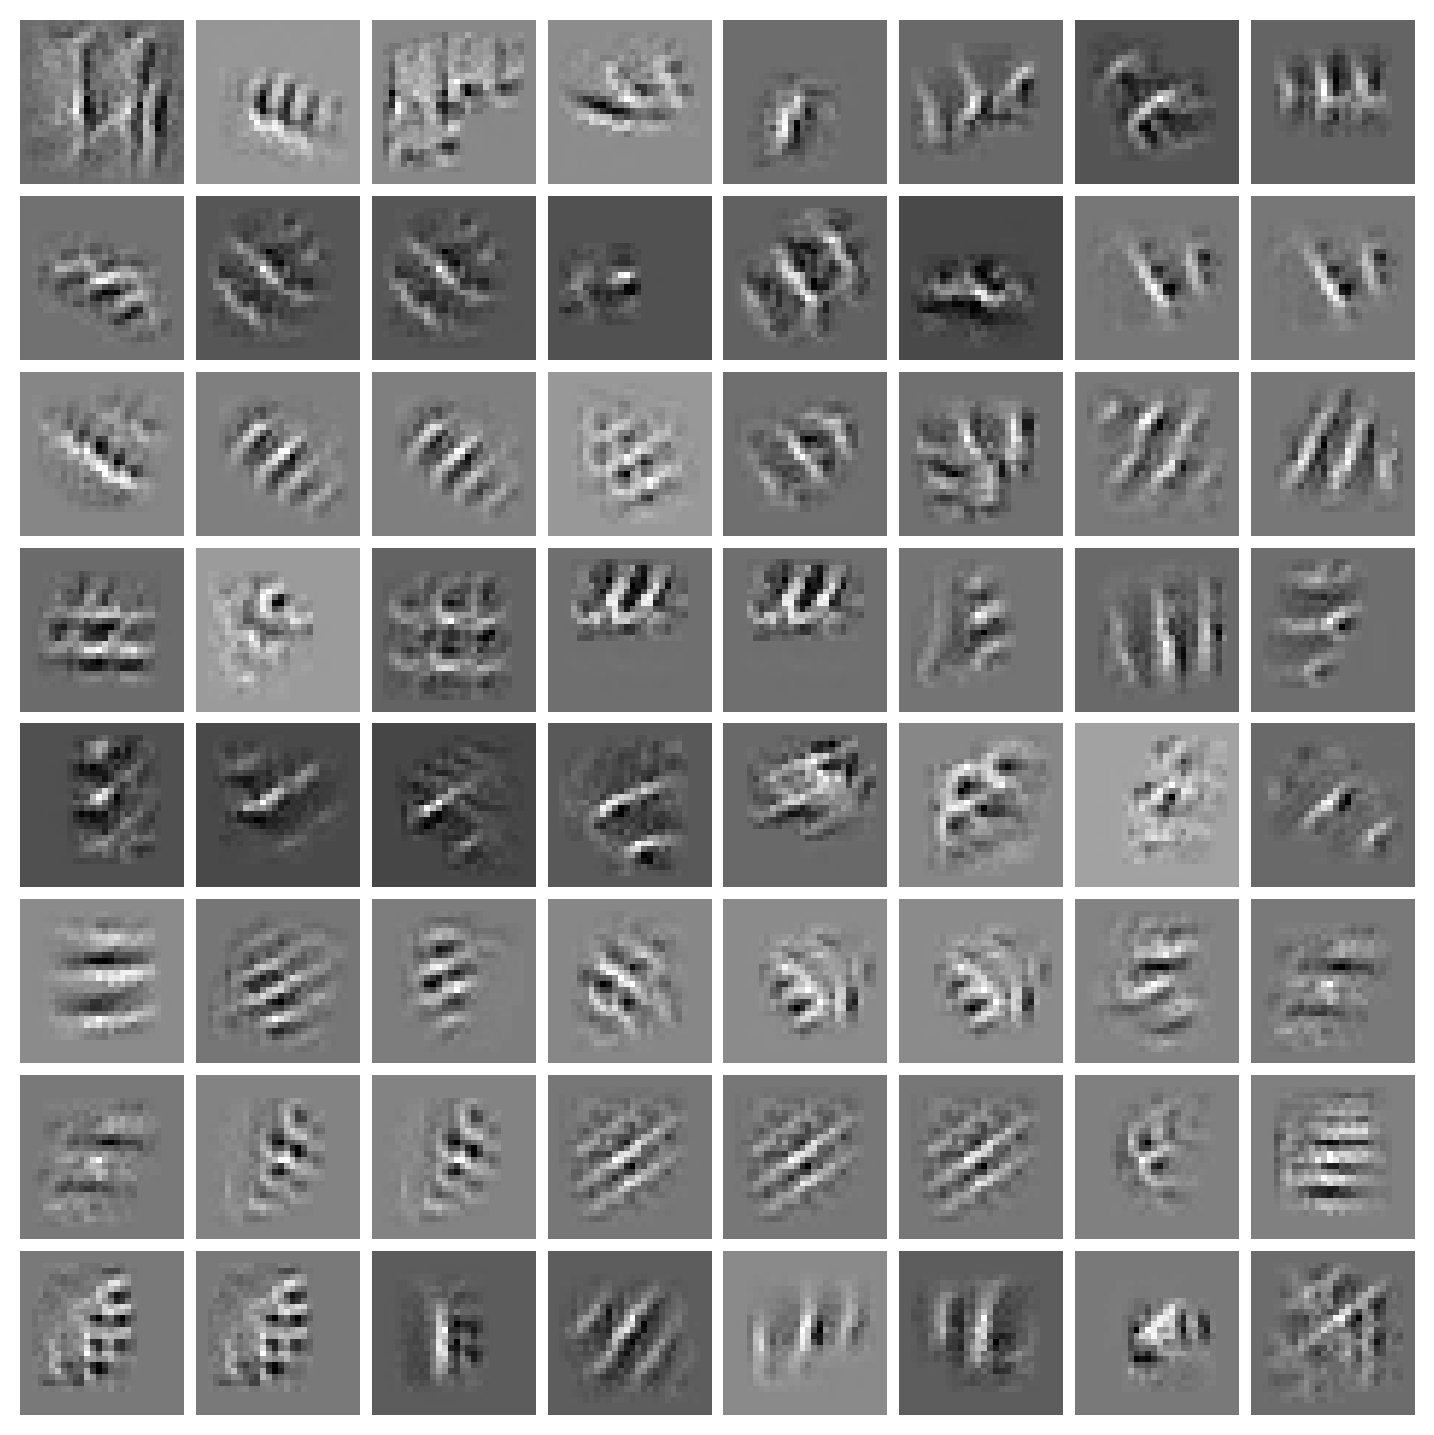

In [ ]:
optim = optax.sgd(10)

n_layers = len(trained_model.layers)
layer_range = [1, 2, 3, 4, 5, 6]
filter_counts = [16, 16, 16, 64, 64, 64]

init_img = jax.random.uniform(jax.random.PRNGKey(0), (28, 28))

for i, l in enumerate(layer_range):
    imgs = []
    filter_count = filter_counts[i]
    for j in range(filter_count):
        img = visualize_receptive_field(img, trained_model.layers[:l+1], j, optim, 30, 31)
        imgs.append(np.array(img))
    wh = int(filter_count ** 0.5)
    tiles(np.array(imgs).reshape(wh, wh, 28, 28))
    print()